In [1]:
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xesmf as xe
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Interpolate the nectdf file downloaded from Copernicus into ROMS grid

In [2]:
# Read the file with data
with xr.open_dataset('Copernicus.nc') as ds:
        ds = ds      
ds

<xarray.Dataset>
Dimensions:         (lat: 56, lon: 89, time: 762)
Coordinates:
  * lon             (lon) float32 2.975 3.025 3.075 3.125 ... 7.275 7.325 7.375
  * time            (time) datetime64[ns] 2018-12-01T12:00:00 ... 2020-12-31T...
  * lat             (lat) float32 58.47 58.53 58.58 58.62 ... 61.12 61.17 61.22
Data variables:
    analysis_error  (time, lat, lon) float32 ...
    analysed_sst    (time, lat, lon) float32 ...
    mask            (time, lat, lon) float32 ...
Attributes: (12/48)
    Conventions:                                    CF-1.4, ACDD-1.3
    title:                                          Global SST & Sea Ice Anal...
    summary:                                        A merged, multi-sensor L4...
    references:                                     Good S, Fiedler E, Mao C,...
    institution:                                    UKMO
    history:                                        Created from sst.nc; obs_...
    ...                                             ...
    publisher_name:                                 GHRSST Project Office
    publisher_url:                                  http://www.ghrsst.org
    publisher_email:                                ghrsst-po@nceo.ac.uk
    processing_level:                               L4
    cdm_data_type:                                  grid
    _CoordSysBuilder:                               ucar.nc2.dataset.conv.CF1...

In [3]:
ds.analysed_sst['units'] = 'celcius (converted from kelvins)' #.data - 273.15
ds = ds.assign(analysed_sst_celsius= ds.analysed_sst - 273.15)
ds #.attrs #analysed_sst.units

<xarray.Dataset>
Dimensions:               (lat: 56, lon: 89, time: 762)
Coordinates:
  * lon                   (lon) float32 2.975 3.025 3.075 ... 7.275 7.325 7.375
  * time                  (time) datetime64[ns] 2018-12-01T12:00:00 ... 2020-...
  * lat                   (lat) float32 58.47 58.53 58.58 ... 61.12 61.17 61.22
Data variables:
    analysis_error        (time, lat, lon) float32 ...
    analysed_sst          (time, lat, lon) float32 282.3 282.3 ... 280.0 279.9
    mask                  (time, lat, lon) float32 ...
    analysed_sst_celsius  (time, lat, lon) float32 9.19 9.18 9.17 ... 6.86 6.8
Attributes: (12/48)
    Conventions:                                    CF-1.4, ACDD-1.3
    title:                                          Global SST & Sea Ice Anal...
    summary:                                        A merged, multi-sensor L4...
    references:                                     Good S, Fiedler E, Mao C,...
    institution:                                    UKMO
    history:                                        Created from sst.nc; obs_...
    ...                                             ...
    publisher_name:                                 GHRSST Project Office
    publisher_url:                                  http://www.ghrsst.org
    publisher_email:                                ghrsst-po@nceo.ac.uk
    processing_level:                               L4
    cdm_data_type:                                  grid
    _CoordSysBuilder:                               ucar.nc2.dataset.conv.CF1...

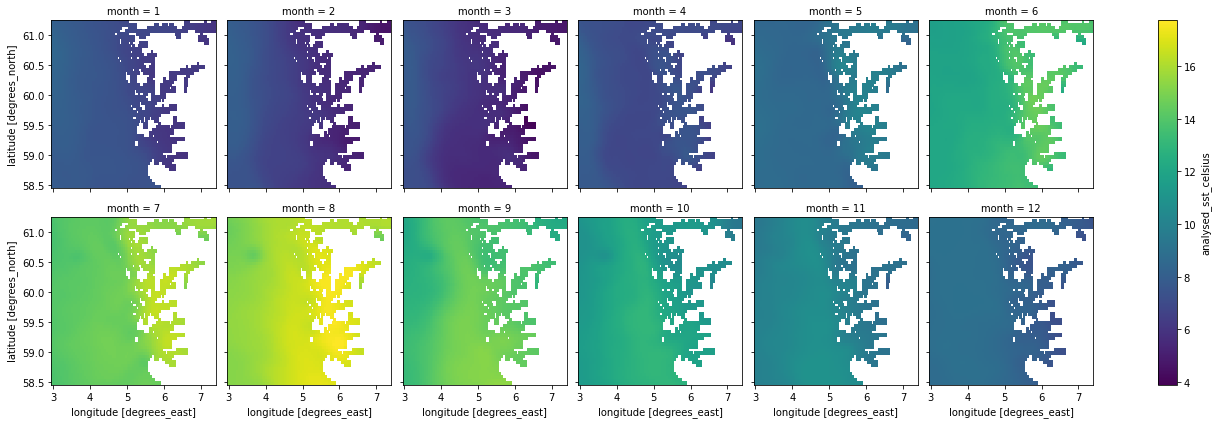

In [4]:
grouped = ds.analysed_sst_celsius.groupby('time.month').mean()
grouped.plot(x="lon", y="lat", col="month", col_wrap=6)

### Plot the old grid against the new grid

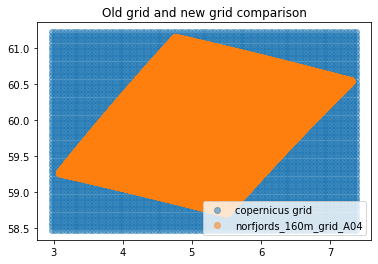

In [5]:
ds_grid = xr.open_dataset('/home/lisapro/OneDrive/Documents/Projects/from Windows/norfjords_160m_grid_A04.nc')
xv, yv = np.meshgrid(ds.isel(time=10).lon.values, ds.isel(time=0).lat.values)

plt.title('Old grid and new grid comparison')
plt.scatter(xv,yv,alpha = 0.5,label = 'copernicus grid')
plt.scatter(ds_grid.lon_rho.values,ds_grid.lat_rho.values,alpha = 0.5,label =  'norfjords_160m_grid_A04')
plt.legend(loc = 'lower right');

### Create regridder 

In [7]:
ds_out = ds_grid.rename({'lon_rho': 'lon', 'lat_rho': 'lat'})
regridder = xe.Regridder(ds.isel(time = 0), ds_out, 'bilinear')
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_56x89_961x1441.nc 
Reuse pre-computed weights? False 
Input grid shape:           (56, 89) 
Output grid shape:          (961, 1441) 
Periodic in longitude?      False

### Apply regridder separately to analysed sst and analysis_error

In [8]:
ds_out = regridder(ds.analysed_sst_celsius)

/home/lisapro/Downloads/anaconda3/envs/romstools/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


In [9]:
ds_out_errors = regridder(ds.analysis_error)

In [11]:
ds_out.to_netcdf('regridded_sst_celsius.nc') #analysed_sst_celsius
ds_out_errors.to_netcdf('regridded_analysis_error.nc') 

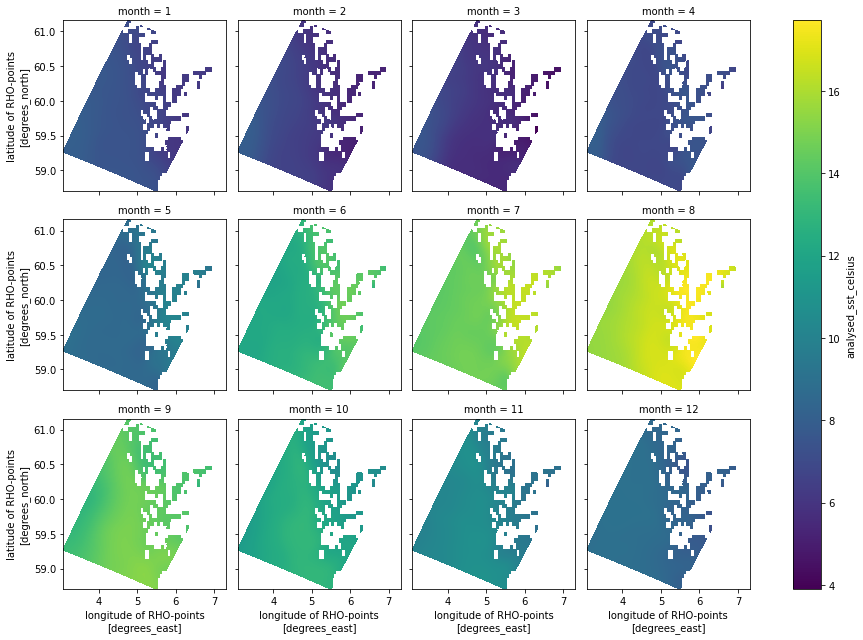

In [26]:
grouped_regridded = ds_out.groupby('time.month').mean()
grouped_regridded.plot(x="lon", y="lat", col="month", col_wrap=4);